In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
from PIL import Image


Processing Winter season
Processing month 12
Found 31 files:
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-01-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-02-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-03-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-04-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-05-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-06-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-07-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-08-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-09-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-10-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-11-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-12-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-13-00000.nc
  - FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-12-14-00000.nc
  - FX2100f19f

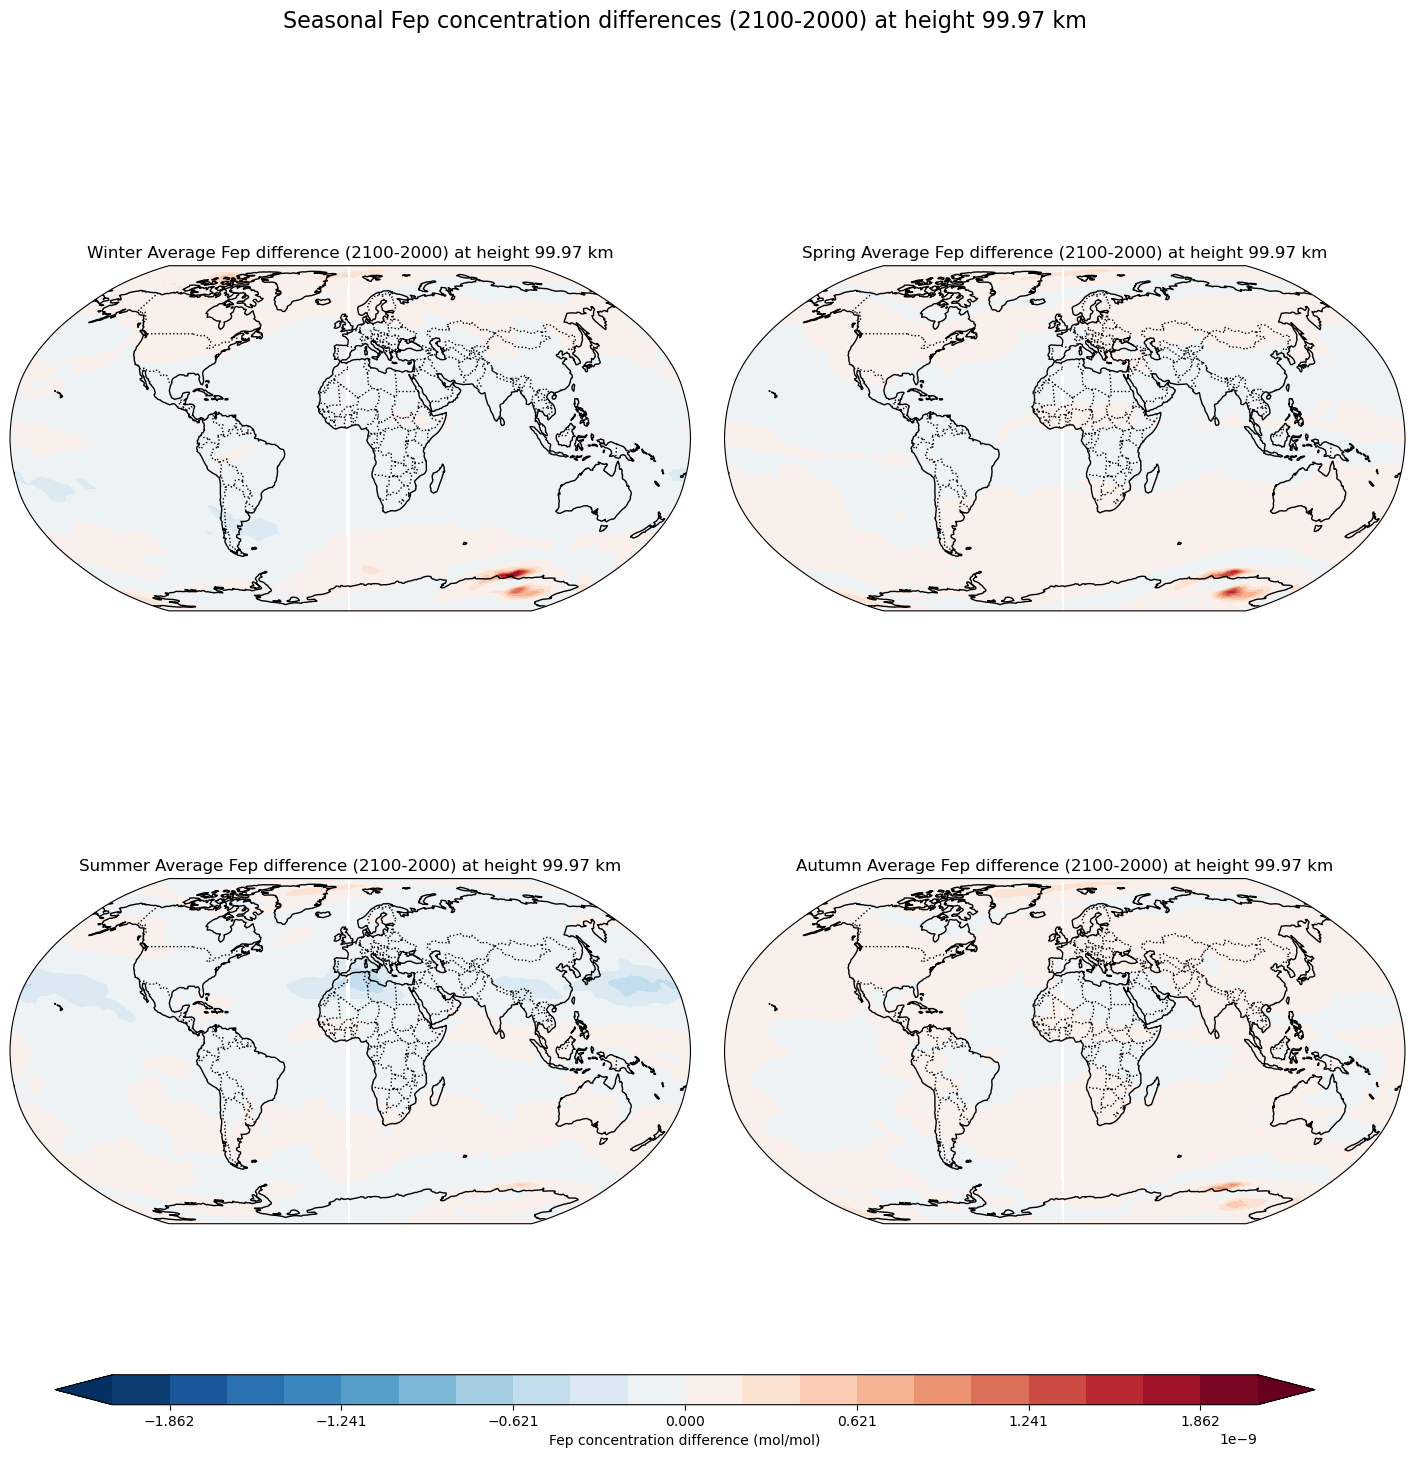

Completed seasonal analysis with 2x2 grid layout


In [3]:
def plot_monthly_avg(files_path, target_month, level_idx):
    all_files = [f for f in os.listdir(files_path) 
                if f.endswith('.nc') and f"{target_month}-" in f]
    
    file_list = []
    for f in all_files:
        if 'SMax' in f and '.h1.' in f:
            file_list.append(os.path.join(files_path, f))
        elif 'FX2100' in f and '.h2.' in f:
            file_list.append(os.path.join(files_path, f))
    
    file_list = sorted(file_list)
    
    if not file_list:
        print(f"No files found for the month {target_month}.")
        return None, None
    
    print(f"Found {len(file_list)} files:")
    for file in file_list:
        print(f"  - {os.path.basename(file)}")
        
    Fep_datasets = []
    for file in file_list:
        try:
            ds = xr.open_dataset(file)
            if 'Fep' in ds:
                Fep_datasets.append(ds.Fep)
            else:
                print(f"Warning: Fep not found in {os.path.basename(file)}")
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    
    if not Fep_datasets:
        print("No valid datasets found with Fep variable.")
        return None, None
        
    combined_Fep = xr.concat(Fep_datasets, dim='time')
    Fep_month_avg = combined_Fep.mean(dim='time').isel(lev=level_idx)
    
    ds = xr.open_dataset(file_list[0])
    mean_altitude_km = None
    try:
        z3_var = ds.variables.get('Z3')
        if z3_var is not None:
            time_idx = min(1, z3_var.shape[0] - 1)  
            h_geopotential = z3_var[time_idx, level_idx, :, :]
            R_e = 6371000.0
            z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
            mean_altitude_m = np.mean(z_geometric)
            mean_altitude_km = mean_altitude_m / 1000.0
        else:
            print("Z3 variable not found for altitude calculation")
    except Exception as e:
        print(f"Error calculating altitude: {e}")
    
    return Fep_month_avg, mean_altitude_km

def plot_seasonal_differences(level_idx=52):
    seasons = {
        'Winter': ['12', '01', '02'],
        'Spring': ['03', '04', '05'],
        'Summer': ['06', '07', '08'],
        'Autumn': ['09', '10', '11']
    }
    
    path_to_daily_files_2100 = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/"
    path_to_daily_files_2000 = "/resstore/b0243/Data/Sporadic_E/Solar_Max/archive_yr2000/atm/hist/"
    
    seasonal_data = {}
    overall_vmin = float('inf')
    overall_vmax = float('-inf')
    altitude = None
    
    for season, months in seasons.items():
        print(f"\nProcessing {season} season")
        
        season_avgs_2100 = []
        season_avgs_2000 = []
        
        for month in months:
            print(f"Processing month {month}")
            
            target_month_2100 = f"2100-{month}"
            avg_2100, alt_2100 = plot_monthly_avg(
                path_to_daily_files_2100, 
                target_month=target_month_2100, 
                level_idx=level_idx
            )
            
            target_month_2000 = f"0001-{month}" 
            avg_2000, alt_2000 = plot_monthly_avg(
                path_to_daily_files_2000, 
                target_month=target_month_2000, 
                level_idx=level_idx
            )
            
            if avg_2100 is None or avg_2000 is None:
                print(f"Skipping month {month} due to missing data")
                continue
                
            season_avgs_2100.append(avg_2100)
            season_avgs_2000.append(avg_2000)
            
            if altitude is None and alt_2100 is not None:
                altitude = alt_2100
        
        if not season_avgs_2100 or not season_avgs_2000:
            print(f"Skipping {season} season due to insufficient data")
            continue
            
        seasonal_avg_2100 = xr.concat(season_avgs_2100, dim='month').mean(dim='month')
        seasonal_avg_2000 = xr.concat(season_avgs_2000, dim='month').mean(dim='month')
        
        seasonal_diff = seasonal_avg_2100 - seasonal_avg_2000
        
        season_vmin = seasonal_diff.min().values
        season_vmax = seasonal_diff.max().values
        overall_vmin = min(overall_vmin, season_vmin)
        overall_vmax = max(overall_vmax, season_vmax)
        
        seasonal_data[season] = seasonal_diff
    
    overall_vmax = max(abs(overall_vmin), abs(overall_vmax))
    overall_vmin = -overall_vmax
    levels = np.linspace(overall_vmin, overall_vmax, 21)
    
    fig = plt.figure(figsize=(18, 15))
    
    season_layout = {
        'Winter': (0, 0),
        'Spring': (0, 1),
        'Summer': (1, 0),
        'Autumn': (1, 1)
    }
    
    projection = ccrs.Robinson()
    
    for season, (row, col) in season_layout.items():
        if season not in seasonal_data:
            continue
            
        seasonal_diff = seasonal_data[season]
        
        subplot_idx = row * 2 + col + 1
        ax = fig.add_subplot(2, 2, subplot_idx, projection=projection)
 
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        mesh = ax.contourf(
            seasonal_diff.lon, 
            seasonal_diff.lat, 
            seasonal_diff,
            transform=ccrs.PlateCarree(),
            levels=levels,
            cmap='RdBu_r',
            extend='both'
        )

        alt_text = f" at height {altitude:.2f} km" if altitude is not None else ""
        ax.set_title(f'{season} Average Fep difference (2100-2000){alt_text}', fontsize=12)

    plt.subplots_adjust(bottom=0.1, wspace=0.05, hspace=0.1)

    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02]) 
    cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Fep concentration difference (mol/mol)')

    if altitude is not None:
        fig.suptitle(f'Seasonal Fep concentration differences (2100-2000) at height {altitude:.2f} km', 
                     fontsize=16, y=0.98)
    else:
        fig.suptitle('Seasonal Fep concentration differences (2100-2000)', fontsize=16, y=0.98)
    
    plt.savefig("Fep_seasonal_differences_2x2.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Completed seasonal analysis with 2x2 grid layout")

plot_seasonal_differences(level_idx=52)